🔄 Loading Results...
✅ Data Loaded. Analyzing 11744 properties.


/var/folders/vt/7xt3j4x53c70jyhvzw06vp8r0000gn/T/ipykernel_13364/326774629.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_10, x='roi_percentage', y='zipcode', palette='viridis', order=top_10['zipcode'])
/Users/ayushagarwal/Documents/rental-arbitrage-engine/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


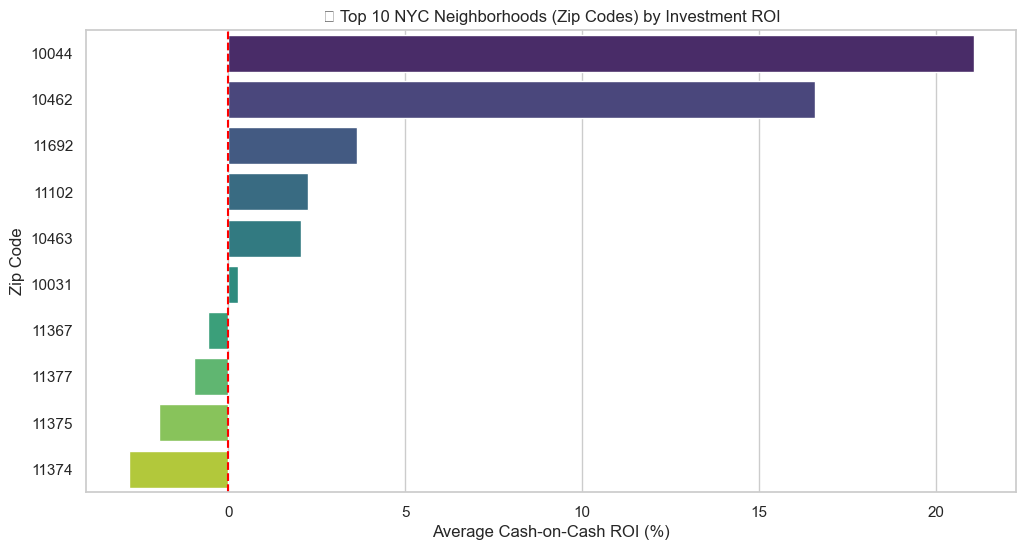

🗺️ Generating Interactive Map...


TypeError: Object of type Timestamp is not JSON serializable

In [3]:
import pandas as pd
import geopandas as gpd
import folium
import matplotlib.pyplot as plt
import seaborn as sns
from folium.plugins import MarkerCluster

# ==========================================
# 1. LOAD DATA
# ==========================================
print("🔄 Loading Results...")
# Load the results from the previous step
df = pd.read_csv('../data/processed/nyc_rental_arbitrage_results.csv')

# Load the Map Shapefile again (for the Choropleth map)
gdf_nyc = gpd.read_file('../data/raw/nyc_zip_codes.geojson')

# Ensure standard CRS
if gdf_nyc.crs != "EPSG:4326":
    gdf_nyc = gdf_nyc.to_crs("EPSG:4326")

# Rename the map column if needed to match your CSV
# (Check your specific geojson column name, usually 'modzcta' or 'postalCode')
if 'modzcta' in gdf_nyc.columns:
    gdf_nyc = gdf_nyc.rename(columns={'modzcta': 'zipcode'})
elif 'postalCode' in gdf_nyc.columns:
    gdf_nyc = gdf_nyc.rename(columns={'postalCode': 'zipcode'})

print(f"✅ Data Loaded. Analyzing {df.shape[0]} properties.")
# ==========================================
# 2. AGGREGATE BY ZIP CODE
# ==========================================
# We need to average the ROI for each Zip Code to color the map
zip_stats = df.groupby('zipcode').agg({
    'roi_percentage': 'mean',
    'zillow_price': 'mean',
    'est_monthly_revenue': 'mean',
    'price': 'mean',
    'id': 'count' # Count listings per zip
}).reset_index()

# Filter: Only keep Zip Codes with at least 10 listings
zip_stats = zip_stats[zip_stats['id'] > 10]

# --- THE FIX IS HERE ---
# Convert both to strings to avoid "ValueError: merge on object and int64"
zip_stats['zipcode'] = zip_stats['zipcode'].astype(str)
gdf_nyc['zipcode'] = gdf_nyc['zipcode'].astype(str)

# Merge stats into the Map Geometry
gdf_map = gdf_nyc.merge(zip_stats, on='zipcode', how='inner')

# ==========================================
# 3. STATIC VISUALIZATIONS (Seaborn)
# ==========================================
import seaborn as sns
sns.set_theme(style="whitegrid")

# Chart A: Top 10 Zip Codes by ROI
plt.figure(figsize=(12, 6))
top_10 = zip_stats.sort_values('roi_percentage', ascending=False).head(10)
sns.barplot(data=top_10, x='roi_percentage', y='zipcode', palette='viridis', order=top_10['zipcode'])
plt.title('🏆 Top 10 NYC Neighborhoods (Zip Codes) by Investment ROI')
plt.xlabel('Average Cash-on-Cash ROI (%)')
plt.ylabel('Zip Code')
plt.axvline(x=0, color='red', linestyle='--', label='Break Even Point')
plt.show()

# ==========================================
# 4. INTERACTIVE MAP (Folium) - The Portfolio Piece
# ==========================================
print("🗺️ Generating Interactive Map...")

# Center map on NYC
m = folium.Map(location=[40.7128, -74.0060], zoom_start=11, tiles='CartoDB positron')

# Define bins that cover ALL possible values
# We go from -1000 to +1000 to catch extreme outliers
my_bins = [-1000, -20, -10, 0, 10, 1000]

# Create Choropleth Layer
choropleth = folium.Choropleth(
    geo_data=gdf_map,
    data=zip_stats,
    columns=['zipcode', 'roi_percentage'],
    key_on='feature.properties.zipcode',
    fill_color='RdYlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Average Cash-on-Cash ROI (%)',
    bins=my_bins  # <--- UPDATED BINS
).add_to(m)

# Add Tooltips (Hover functionality)
folium.GeoJson(
    gdf_map,
    style_function=lambda x: {'fillColor': '#00000000', 'color': '#00000000'},
    tooltip=folium.GeoJsonTooltip(
        fields=['zipcode', 'roi_percentage', 'zillow_price', 'est_monthly_revenue'],
        aliases=['Zip Code:', 'Avg ROI %:', 'Avg Buy Price:', 'Est Revenue:'],
        localize=True
    )
).add_to(m)

# Save Map
m.save('../nyc_roi_map.html')
print("✅ Map Saved as 'nyc_roi_map.html'. Open this file in your browser!")
m # Display map

In [4]:
# ==========================================
# 4. INTERACTIVE MAP (Folium) - The Portfolio Piece
# ==========================================
print("🗺️ Generating Interactive Map...")

# 🛠️ FIX: Select only the columns we need.
# This drops any hidden "Timestamp" columns from the raw shapefile that cause the crash.
cols_needed = ['zipcode', 'roi_percentage', 'zillow_price', 'est_monthly_revenue', 'geometry']
gdf_map_clean = gdf_map[cols_needed].copy()

# Center map on NYC
m = folium.Map(location=[40.7128, -74.0060], zoom_start=11, tiles='CartoDB positron')

# Define bins that cover ALL possible values
my_bins = [-1000, -20, -10, 0, 10, 1000]

# Create Choropleth Layer
choropleth = folium.Choropleth(
    geo_data=gdf_map_clean,        # <--- Use the clean version
    data=zip_stats,
    columns=['zipcode', 'roi_percentage'],
    key_on='feature.properties.zipcode',
    fill_color='RdYlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Average Cash-on-Cash ROI (%)',
    bins=my_bins
).add_to(m)

# Add Tooltips (Hover functionality)
folium.GeoJson(
    gdf_map_clean,                 # <--- Use the clean version
    style_function=lambda x: {'fillColor': '#00000000', 'color': '#00000000'},
    tooltip=folium.GeoJsonTooltip(
        fields=['zipcode', 'roi_percentage', 'zillow_price', 'est_monthly_revenue'],
        aliases=['Zip Code:', 'Avg ROI %:', 'Avg Buy Price:', 'Est Revenue:'],
        localize=True
    )
).add_to(m)

# Save Map
m.save('../nyc_roi_map.html')
print("✅ Map Saved as 'nyc_roi_map.html'. Open this file in your browser!")
m # Display map

🗺️ Generating Interactive Map...
✅ Map Saved as 'nyc_roi_map.html'. Open this file in your browser!
